In [43]:
# Processing experiments around the ROI 
# coding: utf-8

import sys
import os

from pprint import pprint
from collections import OrderedDict

sys.path.insert(0, './src/')

import scipy
import numpy as np
from numpy.random import randint as rint
%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
import plotly 
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib import patches
from matplotlib import animation
from matplotlib.ticker import MaxNLocator
# from IPython.display import HTML
from sklearn import decomposition
from scipy import ndimage
from skimage.filters import roberts
from skimage.filters import sobel
from skimage.filters import prewitt, prewitt_h, prewitt_v
from skimage.transform import downscale_local_mean

from FRAPanalyzer.lifproc import LIFContainer
from FRAPanalyzer.lifproc import start_bioformats
from FRAPanalyzer.lifproc import stop_bioformats
from processing import Processing, win_gaus, win_average
from preprocessing import Preprocessing

In [2]:
plotly.tools.set_credentials_file(username='Serafim-End', api_key='zcYag9TgU0BAofBm0yqA')

In [3]:
# for offline graph demonstration
# init_notebook_mode(connected=True)

Opening wrapper for bioformats

In [4]:
start_bioformats()

BioContainer started


### Brief full image analysis

In order to analize the diffusion of a molecularly thin film / membrane diffusion and protein binding 
we should choose correct and concrete area of our research. Lets look at the full image / process / video of our experiment. 
first of all we have emphasized the diffusion areas by using ellipsoids: 
 - this representation was just for quick diffusion area detection 
 

then we have illustrated the 3D version of the experiment for:
 - to look at values and changes in allocated region
 - to observe the whole process of value changings in the experiment 
 
 
Results: 
- we have chosen just one area from list of 3 areas where you can observe the changes by eyes
- In futher reserch we will use cropped version of ROI 


In [5]:
preproc = Preprocessing(verbose=True)
lsms = preproc.get_lsms()
preproc.prepare_img(lsms[2])
preproc.prepare_rois()

['./test_data/06.04.2014 3T3 HP-Btk FRAP.lsm', './test_data/06.04.2014 3T3 HP-Btk FRAP1.lsm', './test_data/06.04.2014 3T3 HP-Btk FRAP2.lsm']
./test_data/06.04.2014 3T3 HP-Btk FRAP2.lsm


100%|██████████| 156/156 [00:08<00:00, 18.93it/s]

OrderedDict([('06.04.2014 3T3 HP-Btk FRAP2', {'C': 1, 'T': 156, 'Y': 512, 'X': 512, 'Z': 1, 'ID': 'Image:0'})])
{'C': 1, 'T': 156, 'Y': 512, 'X': 512, 'Z': 1, 'ID': 'Image:0'}
(512, 512, 156)


<IPython.core.display.Javascript object>


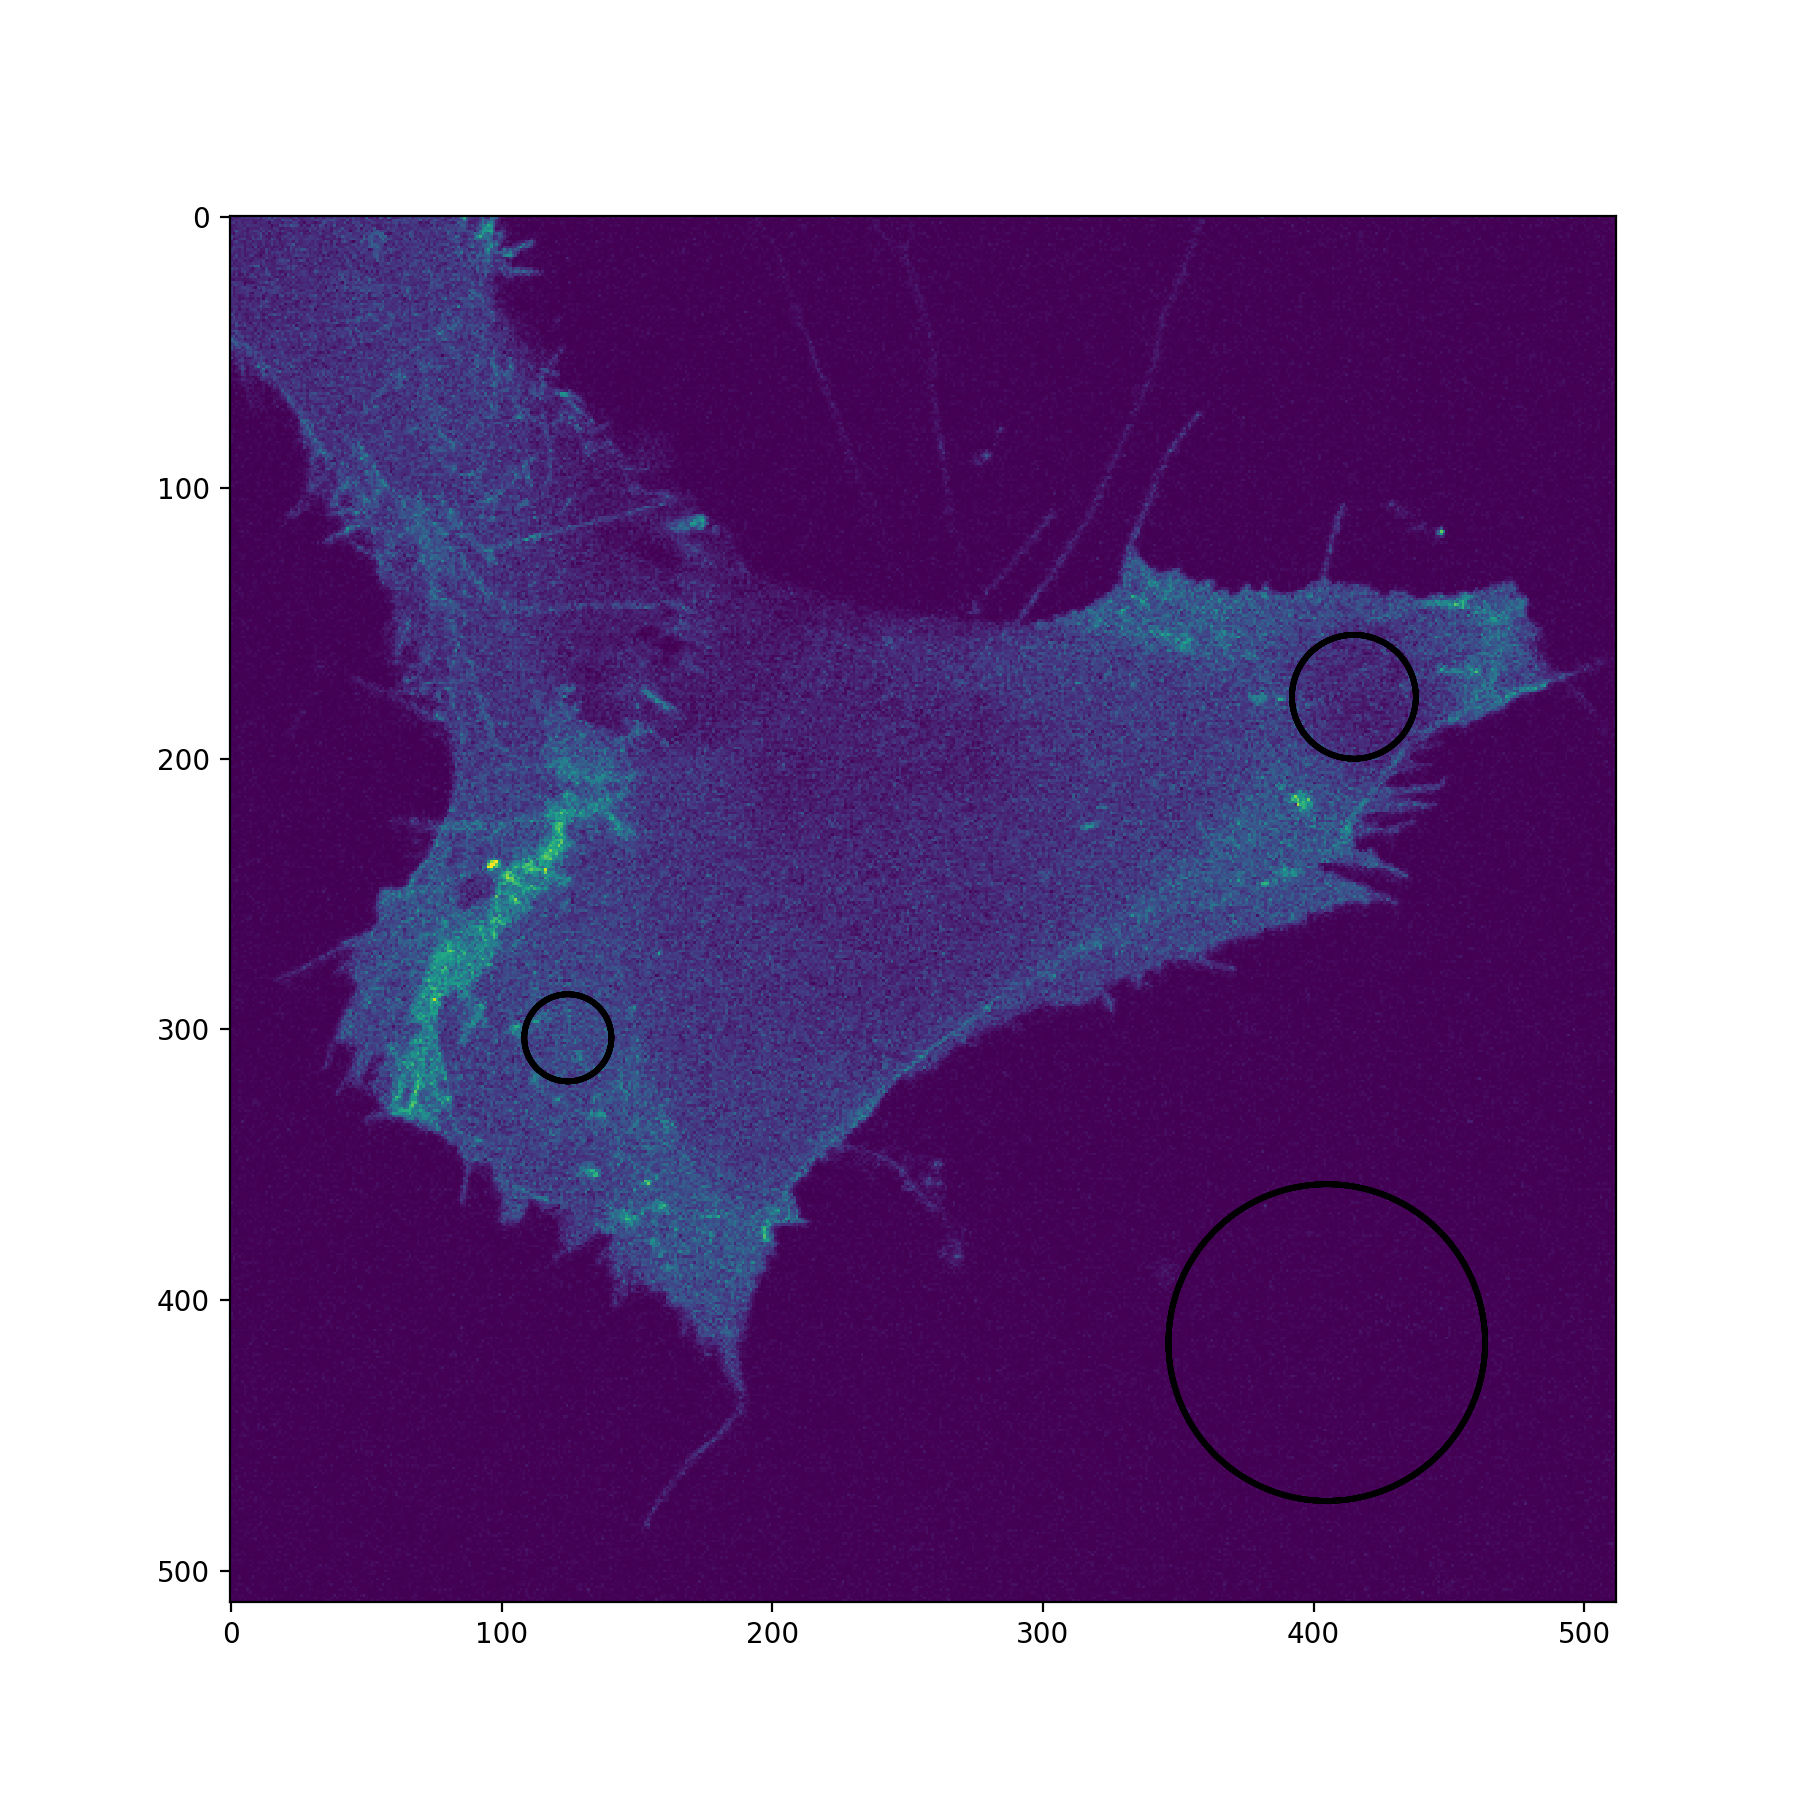

In [6]:
def init():
    ax.set_data(preproc.img[:,:,0])
    return ax,

def animate(i):
    ax.set_data(preproc.img[:,:,i])
    for roi in ['ROI:1', 'ROI:0', 'ROI:2']:
        RadiusX, RadiusY, X, Y = map(preproc.rois_struc[roi][0].get, ('RadiusX', 'RadiusY', 'X', 'Y'))
        ellipse = patches.Ellipse(xy=(X, Y), width=2*RadiusX, height=2*RadiusY, linewidth=2.0, fill=False)
        ax.get_figure().gca().add_artist(ellipse)
    ax.set_title('#{}'.format(i))
    return ax,
    
fig = plt.figure(figsize=(9,9))
ax = plt.imshow(preproc.img[:,:,0])
    
anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=preproc.img.shape[-1], interval=1000, blit=True)

In [7]:
def plot_plotly_svd(ar, filename='analyse', dim=(64,64), end_step=61):

    data = [
        go.Surface(
            z=np.reshape((ar)[:,step], dim),
            visible=False,
            name='v=' + str(step),
            zmax=250,
            zmin=-250,
            zauto=False
        ) for step in xrange(0, end_step)
    ]

    data[2]['visible'] = True

    steps = []
    for i in range(len(data)):
        step = dict(
            method = 'restyle',
            label = str(i),
            args = ['visible', [False] * len(data)],
        )
    
        step['args'][1][i] = True 
        steps.append(step)

    sliders = [dict(
        active = 10,
        currentvalue = {"prefix": "Frame: "},
        pad = {"t": 50},
        steps = steps
    )]
    
    updatemenus=list([
        dict(
            buttons=list([   
                dict(
                    args=['type', 'surface'],
                    label='3D Surface',
                    method='restyle'
                ),
                dict(
                    args=['type', 'heatmap'],
                    label='Heatmap',
                    method='restyle'
                ),
                dict(
                    args=['type', 'contour'],
                    label='Contour',
                    method='restyle'
                ) 
            ]),
            direction = 'left',
            pad = {'r': 10, 't': 10},
            showactive = True,
            type = 'buttons',
            x = 0.1,
            xanchor = 'left',
            y = 1.1,
            yanchor = 'top' 
        ),
    ])

    layout = dict(
        sliders=sliders,
        width=700,
        height=800,
        autosize=False,
        margin=dict(t=0, b=0, l=0, r=0),
    )
    
    layout['updatemenus'] = updatemenus
    
    fig = dict(data=data, layout=layout)
    return py.iplot(fig, filename=filename)

Remark: 
- we cannot see exactly the real trend of value changes in this 3D plot, 
- but it is usefull to understand the whole experiment value changes

Result: 
if we know the concrete frame and location of conrete region of interests then we can observe the diffusion by eyes in other cases we cannot.

In [271]:
preproc_pre_img = np.stack(
    [downscale_local_mean(preproc.img[:,:,i], (6, 6)) for i in xrange(preproc.img.shape[-1])], axis=2)
print preproc_pre_img.shape
plot_plotly_svd(np.reshape(preproc_pre_img, (86*86, 156)), dim=(86,86), end_step=100)

(86, 86, 156)


Loading experiment *.lif* file

In [8]:
lif = LIFContainer('./test_data/Experiment_001.lif')

Looking for a structure in wrapped object

In [9]:
lif.lif_img_data

OrderedDict([('Image005',
              {'C': 3, 'ID': 'Image:0', 'T': 1, 'X': 512, 'Y': 512, 'Z': 1}),
             ('FRAP/FRAP Series09',
              {'C': 2, 'ID': 'Image:1', 'T': 127, 'X': 128, 'Y': 128, 'Z': 1}),
             ('FRAP_004/FRAP Series16',
              {'C': 1, 'ID': 'Image:2', 'T': 369, 'X': 64, 'Y': 64, 'Z': 1}),
             ('FRAP/FRAP Series18',
              {'C': 1, 'ID': 'Image:3', 'T': 787, 'X': 64, 'Y': 64, 'Z': 1})])

Selecting series of images

In [10]:
series_id = 'FRAP_004/FRAP Series16'

Loading images to numpy array

In [11]:
img = lif.get_full_array(series_id, progressbar=True)

100%|██████████| 369/369 [00:21<00:00, 17.12it/s]


In [12]:
# Example of how to load full experiment array
# NOW: this approach was included inside the the lif package therefore no reason to use it
# but if you wanna see only raw data in array format this approach will be useful for you
# img = wrp.get_full_array('FRAP_001/FRAP Series10')
# series_name = 'FRAP_001/FRAP Series10'

print(lif.lif_img_data[series_id])
current_series_id = lif.lif_series_order.index(series_id)

{'C': 1, 'T': 369, 'Y': 64, 'X': 64, 'Z': 1, 'ID': 'Image:2'}


In [13]:
# dimensionality reduction
# one experiment should consist of series single pictures

if len(img.shape) > 3:
    img = img[:,:,0,:]

# check the correctness 
img.shape

(64, 64, 369)

In [14]:
# Customizations

save_video_experiments = False

t = 60
x_, y_ = 33.0, 28.5 # the centre of bleach region
R = 17 # the radious of bleach redion
t_last = 61

# area = R**2 * np.pi * 255

### Visualization of bleaching

In [15]:
img.shape

(64, 64, 369)

<IPython.core.display.Javascript object>


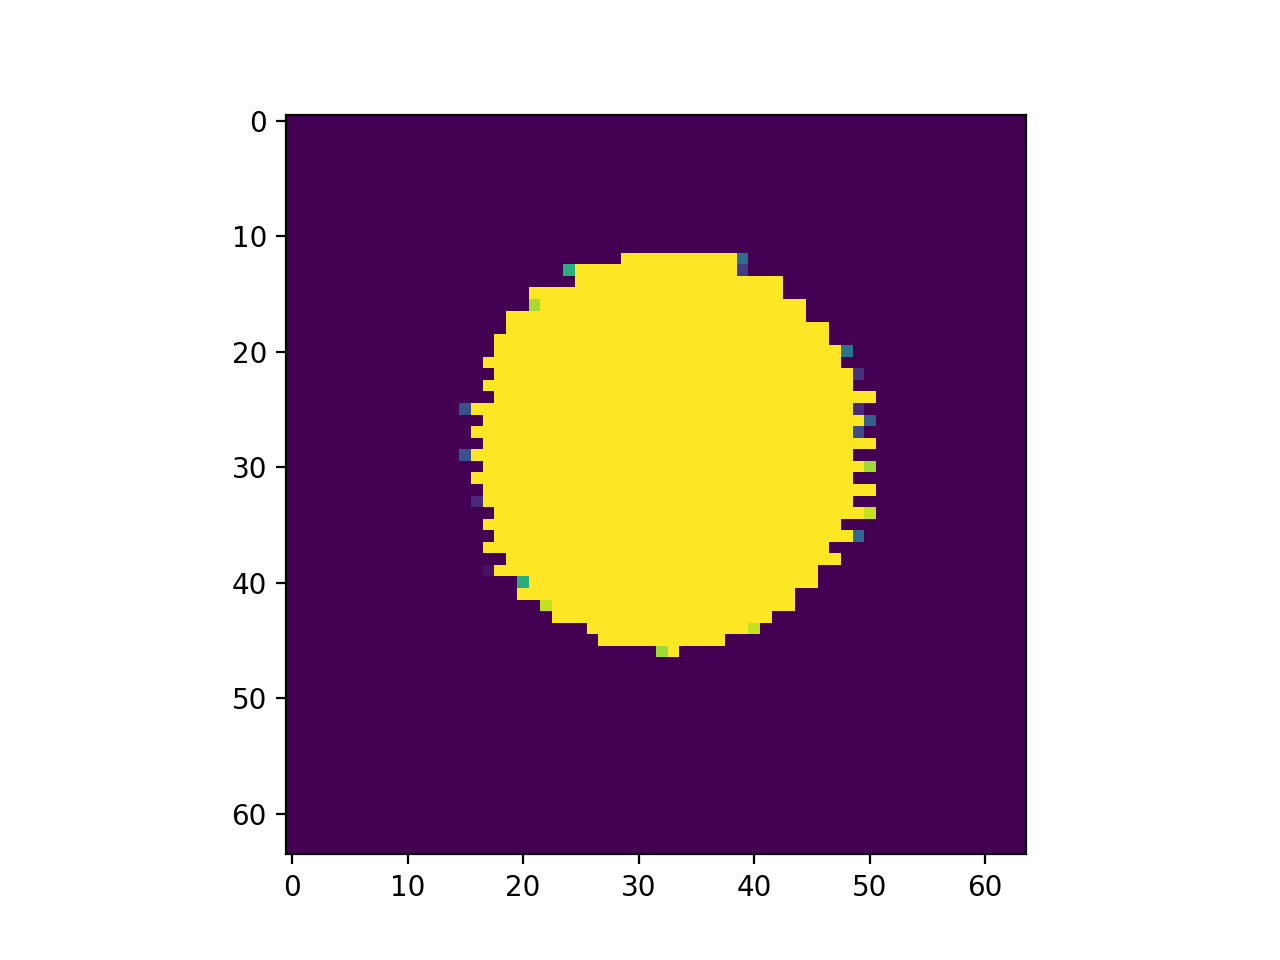

In [16]:
# prebleach 0-1, bleach 1 - 60 , after-bleach 61

# contour around the ROI
# just int value contour
    
fig = plt.figure()
ax = plt.imshow(img[:,:,0])    
    
def f_border(a, edge=int):
    return np.array([edge(e) for e in a])
    
def init():
    ax.set_data(np.zeros_like(img[:,:, 0]))
    return ax,
    
def animate(i): 
    
    i = img.shape[-1] if i > t_last else i
    
    t = np.linspace(0, np.pi * 2, img.shape[-1])
    x = x_ + R * np.sin(t)
    y = y_ + R * np.cos(t)
    x, y = f_border(x), f_border(y)
    ax.set_data(img[:, :, i])
    return ax,

anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=61,
    blit=True, interval=100, repeat=False
)

if save_video_experiments:
    anim.save('basic_animation_experiment.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

###### Beginning analysis, lets look at FRAP: 

- observe the recovery process 
- detect the immobile and mobile rates

In [38]:
_img = np.reshape(img, (4096, 369))

plateau = _img[:,150:350].sum(axis=0).mean()
max_ = _img.sum(axis=0).max()
print 'plateau: ', plateau, ' max: ', max_, ' rate immobile: ', plateau / max_

plateau:  534.50978017  max:  949.901962614  rate immobile:  0.562699942949


In [37]:
py.iplot([
    go.Scatter(x=range(img.shape[-1]),
               y=[img[:,:,i].sum() for i in range(img.shape[-1])], 
               line = dict(color = ('rgb(205, 12, 24)'), width = 4), name='FRAP'),
    go.Scatter(x=range(img.shape[-1]),
               y=[plateau for i in range(img.shape[-1])], 
               line = dict(color = ('rgb(25, 200, 24)'), width = 4), name='plateau'),
    go.Scatter(x=range(img.shape[-1]),
               y=[max_ for i in range(img.shape[-1])], 
               line = dict(color = ('rgb(25, 200, 24)'), width = 4), name='max'),
])

# Preprocessing, SVD decomposition


other variants of "stable" decomposition are factorizations. Good variants are:
- LU factorization
 

In [41]:
scale = 100
M = img
M.shape

(64, 64, 369)

an attemp to detect correct number of eigen values.
In this case we can see that 1 component can illustrate the most valuable meanings 

![svd](https://preview.ibb.co/n7AKba/svd.png)

In [42]:
U, s, V = np.linalg.svd(M, full_matrices=True)
py.iplot(
    [go.Scatter(x = np.arange(s.shape[0]), y = s.diagonal(), name='all values'),
     go.Scatter(x = np.arange(2), y = s.diagonal()[:2], 
                line = dict(color = ('rgb(205, 12, 24)'), width = 4),
                name='1 component')],
    filename='svd-number-eigen-values-detection'
)

# print s.diagonal()

We can see that full image decomposition cannot help us to understand the ROI

therefore we will not use svd decomposition production, but it can help compare this result with others image smoothings in further reserch

<IPython.core.display.Javascript object>


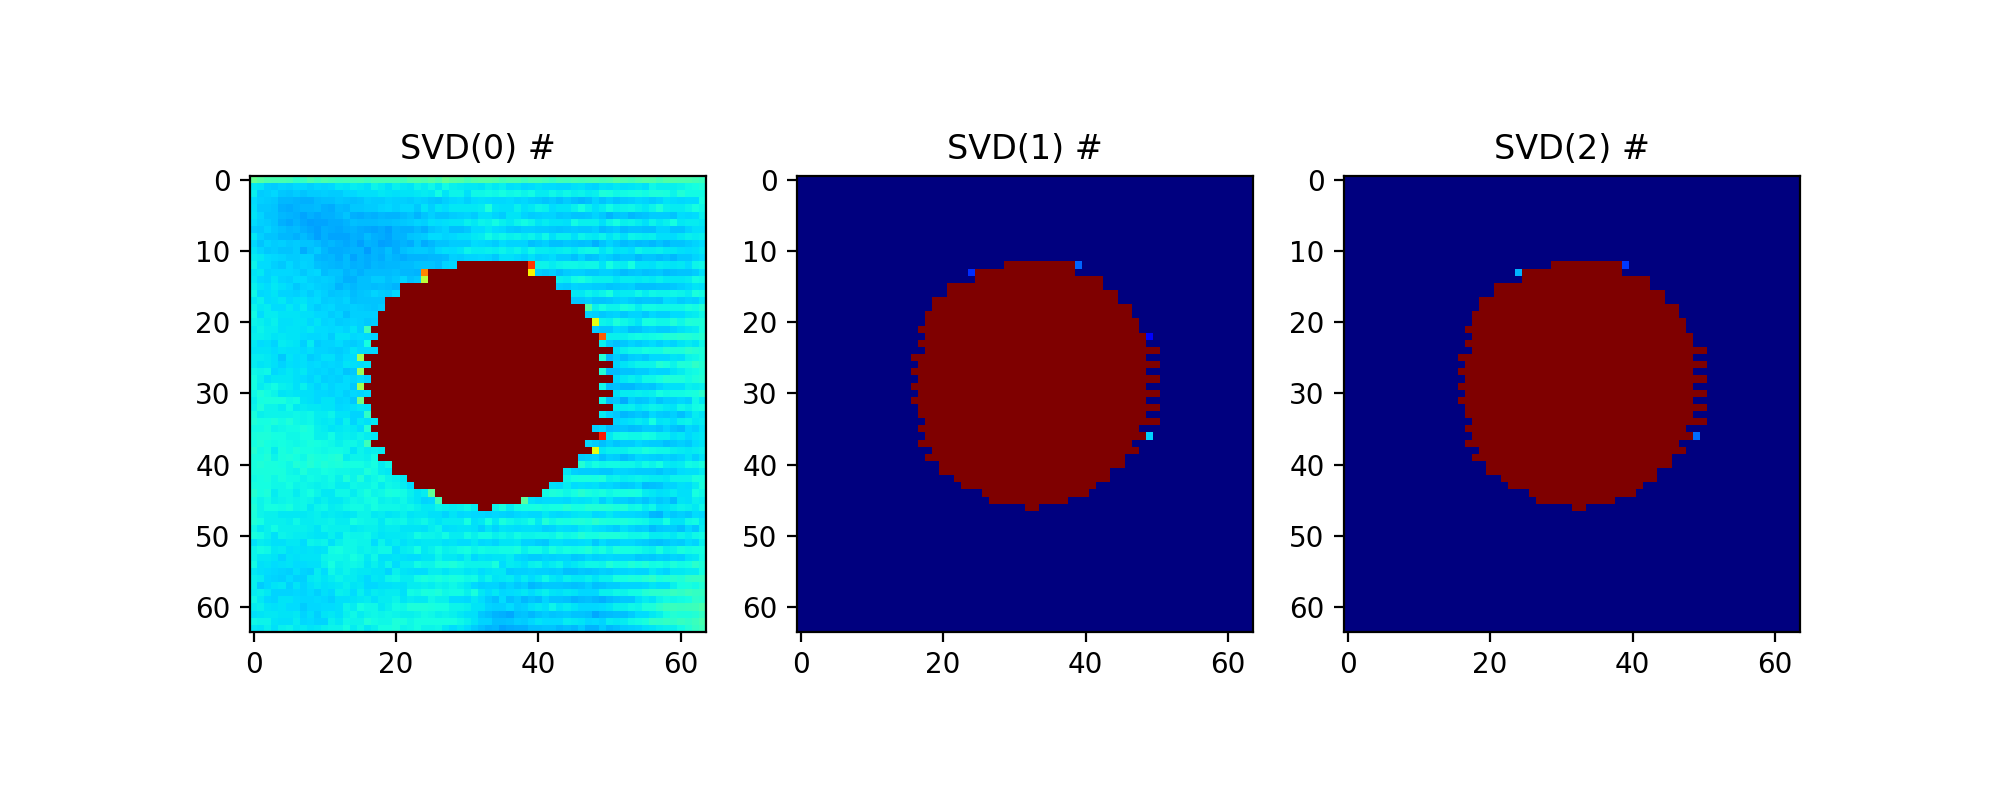

In [49]:
n_components = 3
M = np.reshape(M, (64*64, 369))

low_rank = []
for i in xrange(1, n_components + 1):
    u, s, v = decomposition.randomized_svd(M, n_components=i)
    usv = np.reshape(np.dot(u, np.dot(np.diag(s), v)), (64, 64, 369))
    low_rank.append(usv)
    
fig, axs = plt.subplots(1, n_components, figsize=(10, 4))

titles = ['SVD({}) #'.format(e) for e in xrange(n_components)]
for i, ax in enumerate(axs):
    ax.set_title(titles[i])

hs = [axs[i].imshow(low_rank[i][:,:,0], cmap=plt.cm.jet) for i in xrange(n_components)]
def init():
    for i, h in enumerate(hs):
        h.set_data(np.zeros_like(low_rank[i][:,:,0]))
    return tuple(hs)

def animate(i):
    for ind, h in enumerate(hs):
        h.set_data(low_rank[ind][:,:,i])
    for j, ax in enumerate(axs):
        ax.set_title(titles + str(i))
    return tuple(hs)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=61, interval=20, blit=True)

In [50]:
M_ = np.reshape(M, (64,64,369))

Results of svd decomposition applying for smoothing: 
- the fact that the number of independent eigen vectors is one => just one eigen value pick in S diagonal matrix in the decomposition (first line on the picture) could not help 

In [52]:
data = [
    go.Scatter(x=range(e.shape[-1]), y=[e[:,:,i].sum() for i in range(e.shape[-1])],
               line = dict( width = 4))
    for e in low_rank
] 
py.iplot(data)

In [297]:
print(__doc__)

import sklearn
from sklearn.decomposition import FastICA, PCA

Automatically created module for IPython interactive environment


In [298]:
# uncomment below to use ipython widgets

# import ipywidgets as widgets
# from ipywidgets import interact, interactive, fixed
# from IPython.display import display, clear_output

In [212]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(M[:,40])  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
models = [S_]

fig = tools.make_subplots(rows=1, cols=1,
                          subplot_titles=('ICA',),
                          print_grid=False)
row = 1
for ii, model in enumerate(models):
    for sig, color in zip(model.T, ['orange']):
        trace = go.Scatter(y=sig, 
                           showlegend=False,
                           line=dict(color=color))
        fig.append_trace(trace, row, 1)

    row+=1
    
fig['layout'].update(height=800)
py.iplot(fig)

In [242]:
data = [
    go.Surface(
        z=np.reshape((M - low_rank[0])[:,40], (64,64))
    )
]
layout = go.Layout(
    title='boundary directions',
    autosize=True,
)
fig = go.Figure(data=data, layout=layout)

In [243]:
url = py.plot(figure_or_data=fig, filename='boundary_directions', auto_open=False)
print url

https://plot.ly/~Serafim-End/32


In [244]:
py.iplot(fig)

In [245]:
plot_plotly_svd(np.reshape(M, (64*64, 369)))

# QR factorization

Instead of SVD decomposition we can use factorization methods

qr factorization:

![qrfactorization](https://image.ibb.co/f9LVhF/qr.png)

Data preparation 

an attempt to pass data through the factorization (some kind if preprocessing)

In [236]:
Q, R = scipy.linalg.qr(np.reshape(M, (64*64, 369)), mode='economic')
plot_plotly_svd(np.dot(Q, R))

# Experiments

### Applying sobel filters to images
explonation of sobel filter
![sobel_explonatino](http://people.ece.cornell.edu/land/courses/ece5760/FinalProjects/s2013/cwf38_as889_mao65/images/sobel_convolution.png)

### Visualization of sobel filter components
 where Gx - horizontal filter and Gy - vertical filter and Sobel filter is G
 
The experiment results show that there is a sense to consider a convolution of the coordinates to understand the weight each of value (each direction). The video shows that the weights of horizontal component stronger (both positive and negative aspects of component) that shown as dark color. Consequently, on the resulting filter this effect can be observed.

In [254]:
from skimage.filters import (sobel_h, sobel_v)

sh_frames = np.zeros(img.shape[:2] + (t_last,))
sv_frames = np.zeros(img.shape[:2] + (t_last,))
sob_frames = np.zeros(img.shape[:2] + (t_last,))

ph_frames = np.zeros(img.shape[:2] + (t_last,))
pv_frames = np.zeros(img.shape[:2] + (t_last,))
prew_frames = np.zeros(img.shape[:2] + (t_last,))

for i in range(t_last,):
    sh_frames[:,:,i] = sobel_h(img[:,:,i])
    sv_frames[:,:,i] = sobel_v(img[:,:,i])
    sob_frames[:,:,i] = np.sqrt(sh_frames[:,:,i]**2 + sv_frames[:,:,i]**2)
    sob_frames[:,:,i] /= np.sqrt(2)
    
    ph_frames[:,:,i] = prewitt_h(img[:,:,i])
    pv_frames[:,:,i] = prewitt_v(img[:,:,i])
    prew_frames[:,:,i] = np.sqrt(ph_frames[:,:,i]**2 + pv_frames[:,:,i]**2)
    prew_frames[:,:,i] /= np.sqrt(2)    

In [255]:
sh_avg, sv_avg, sob_avg = win_average(sh_frames, n=5), win_average(sv_frames, n=5), win_average(sob_frames, n=5)
ph_avg, pv_avg, prew_avg = win_average(ph_frames, n=5), win_average(pv_frames, n=5), win_average(prew_frames, n=5)

<IPython.core.display.Javascript object>


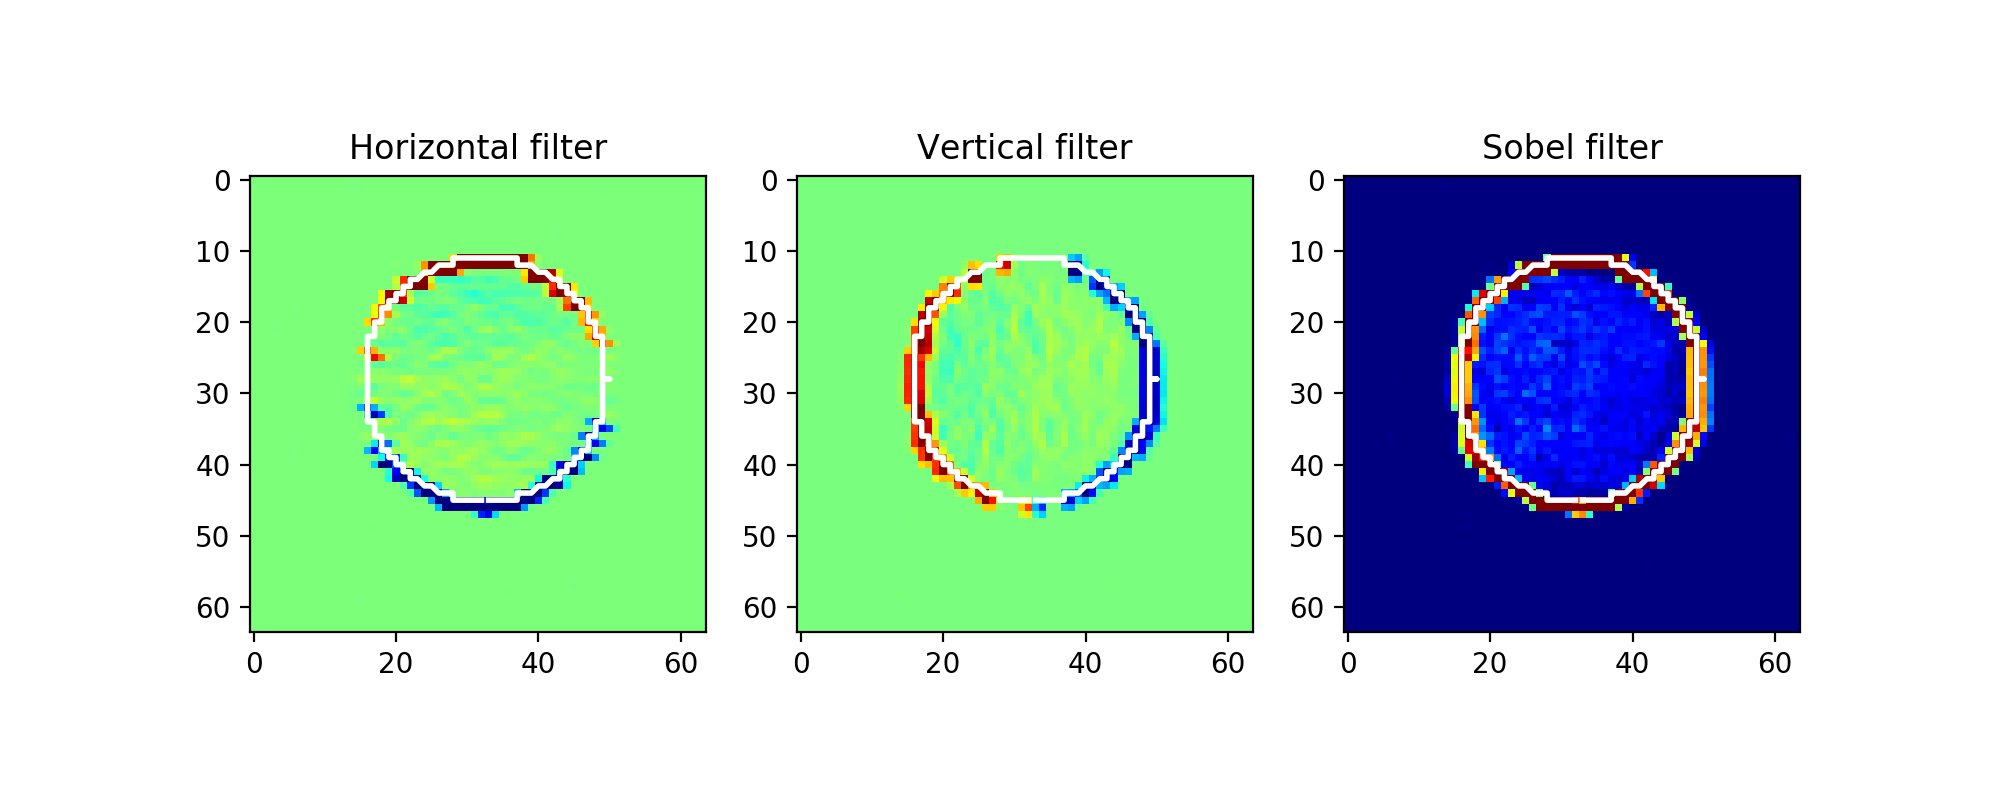

In [273]:
t = np.linspace(0, np.pi * 2, img.shape[-1])
x, y = x_ + R * np.sin(t), y_ + R * np.cos(t)
x, y = f_border(x), f_border(y)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.set_title('Horizontal filter')
ax2.set_title('Vertical filter')
ax3.set_title('Sobel filter')

h1 = ax1.imshow(sh_avg[:,:,0], cmap=plt.cm.jet)
h2 = ax2.imshow(sv_avg[:,:,0], cmap=plt.cm.jet)
h3 = ax3.imshow(sob_avg[:,:,0], cmap=plt.cm.jet)

ax1.plot(x, y, color='w', linewidth=2.0)
ax2.plot(x, y, color='w', linewidth=2.0)
ax3.plot(x, y, color='w', linewidth=2.0)

def init():
    h1.set_data(np.zeros_like(sh_avg[:,:,0]))
    h2.set_data(np.zeros_like(sv_avg[:,:,0]))
    h3.set_data(np.zeros_like(sob_avg[:,:,0]))
    return h1, h2, h3

def animate(i):
    h1.set_data(sh_avg[:,:,i])
    h2.set_data(sv_avg[:,:,i])
    h3.set_data(sob_avg[:,:,i])
    return h1, h2, h3

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sv_avg.shape[-1], interval=20, blit=True)

if save_video_experiments:
    anim.save('basic_animation_sobel.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

In [261]:
py.iplot([
    go.Scatter(x=range(sob_avg.shape[-1]), y=[sob_avg[:,:,i].sum() for i in range(sob_avg.shape[-1])],
               line = dict(color = ('rgb(205, 12, 24)'), width = 4), name='values'),
])

<IPython.core.display.Javascript object>


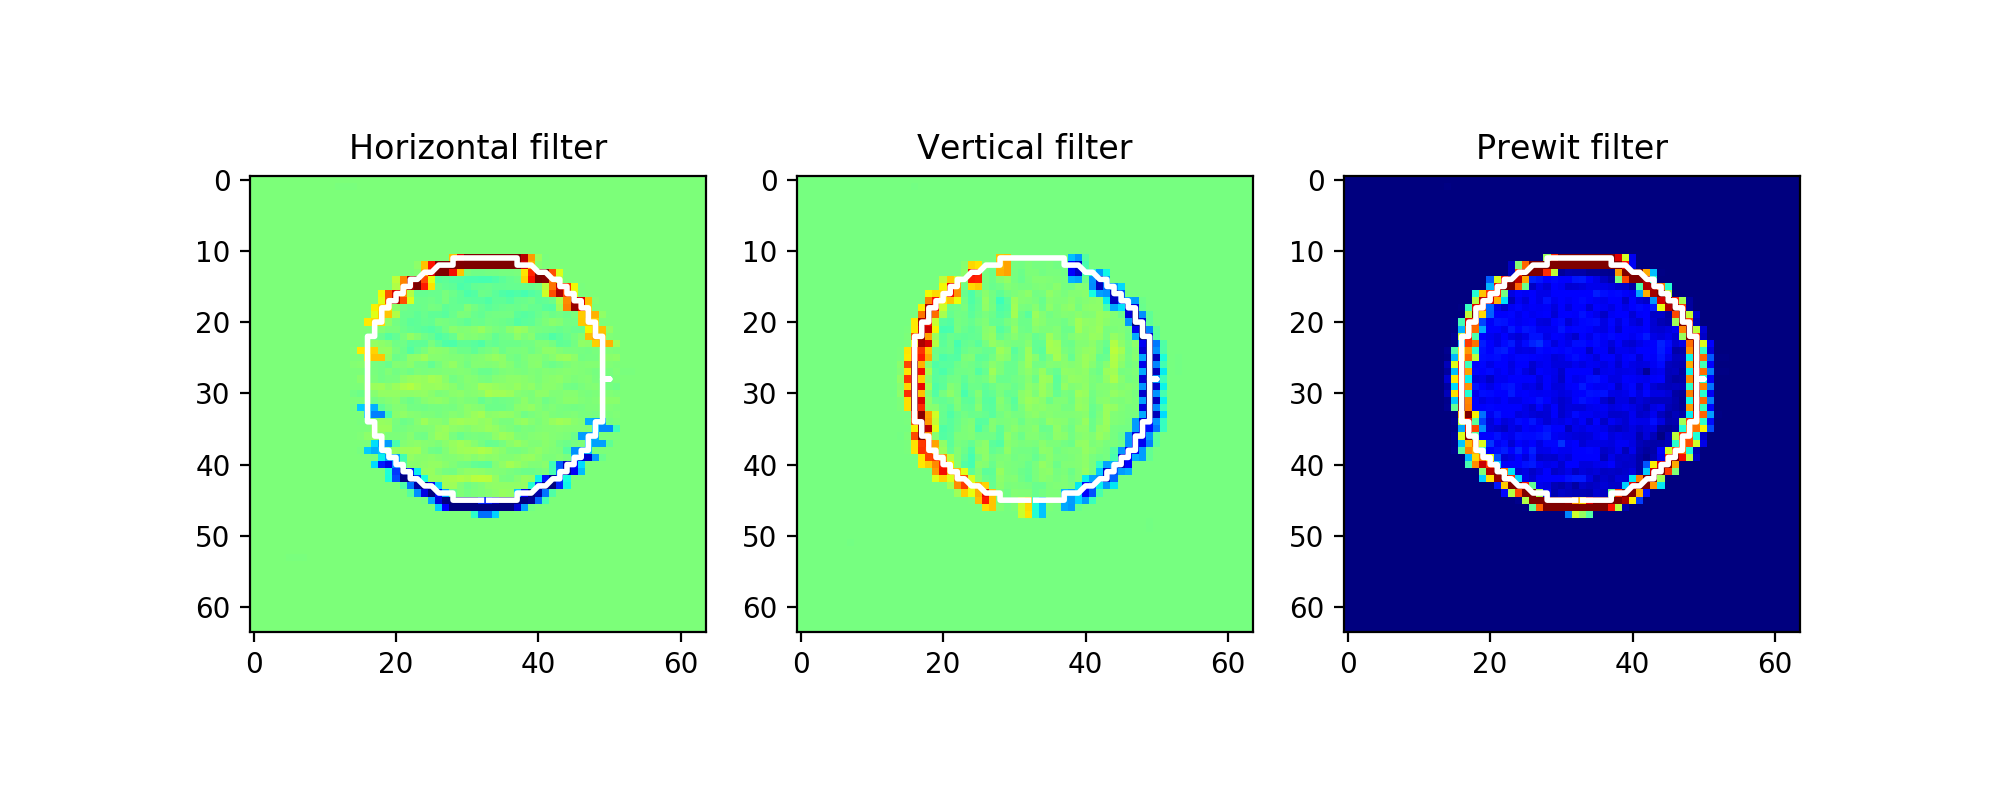

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

titles = ['Horizontal filter', 'Vertical filter', 'Prewit filter']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])

hs = [axs[0].imshow(ph_avg[:,:,0], cmap=plt.cm.jet), axs[1].imshow(pv_avg[:,:,0], cmap=plt.cm.jet),
      axs[2].imshow(prew_avg[:,:,0], cmap=plt.cm.jet)]

for ax in axs:
    ax.plot(x, y, color='w', linewidth=2.0)

arrs = [ph_avg, pv_avg, prew_avg]
def init():
    for i, h in enumerate(hs):
        h.set_data(np.zeros_like(arrs[i][:,:,0]))
    return tuple(hs)

def animate(i):
    for ind, h in enumerate(hs):
        h.set_data(arrs[ind][:,:,i])
    return tuple(hs)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sv_avg.shape[-1], interval=20, blit=True)
if save_video_experiments:
    anim.save('basic_animation_prewitt.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

# Gaussian for image
![gaussian](http://campar.in.tum.de/twiki/pub/Chair/HaukeHeibelGaussianDerivatives/gauss2d00.png)

in this case we wanna make filter that will count the max weight for the center pixel in the mask, in other words it is a simple convolution with max weight in the center of mask. 
![gaussian_explonation](https://www.researchgate.net/profile/Yasuaki_Ito/publication/294424568/figure/fig12/AS:330299767574530@1455761009308/Figure-4-Illustrating-a-window-of-size-m-m-a-Gaussian-filter-of-size-2w-1-2w.png)

### Visualization of Gaussian + (Sobel, Roberts, Prewitt) edge detection

Experiment steps:
- manual bleaching border tuning (choose R, (x, y) - centre of bleaching area)
- Gaussian averaging on the images
- Sobel, Roberts, Prewitt filter

Experiment results:
- the application of Sobel filter shows general direction of gradient diff - we can observe the region of grafdient diff. This trend can be observed with all sigmas.
- the application of Roberts filter shows more sensetive behaviour to gradient diff. It illustrates the wave behaviour (if changes are significant it can be clearly seen by color)
- the application of Prewitt filter illustrates significant gradient diff in small Gaussian sigma context and made it better than Sobel filter

Результаты эксперимента: 
- Применения фильтра Собеля отображает общее движение (направление) градиента в каждый момент времени, можно наблюдать лишь область, в которой градиент меняется сильнее всего. Тенденцию можно прослеживать при любой сигме. 
- Применение фильтра Робертса позволяет увидеть более точечные изменения, но неравномерное изменение - всплески не позволяют интропретирвоать резульаты. По мере увеличения сигмы результаты становятся более похожими на применение Собеля
- Применение фильтра Превита хорошо иллюстрирует значительные изменения градиента при использовании малой сигмы - точнее, чем фильтр Собеля.

<IPython.core.display.Javascript object>


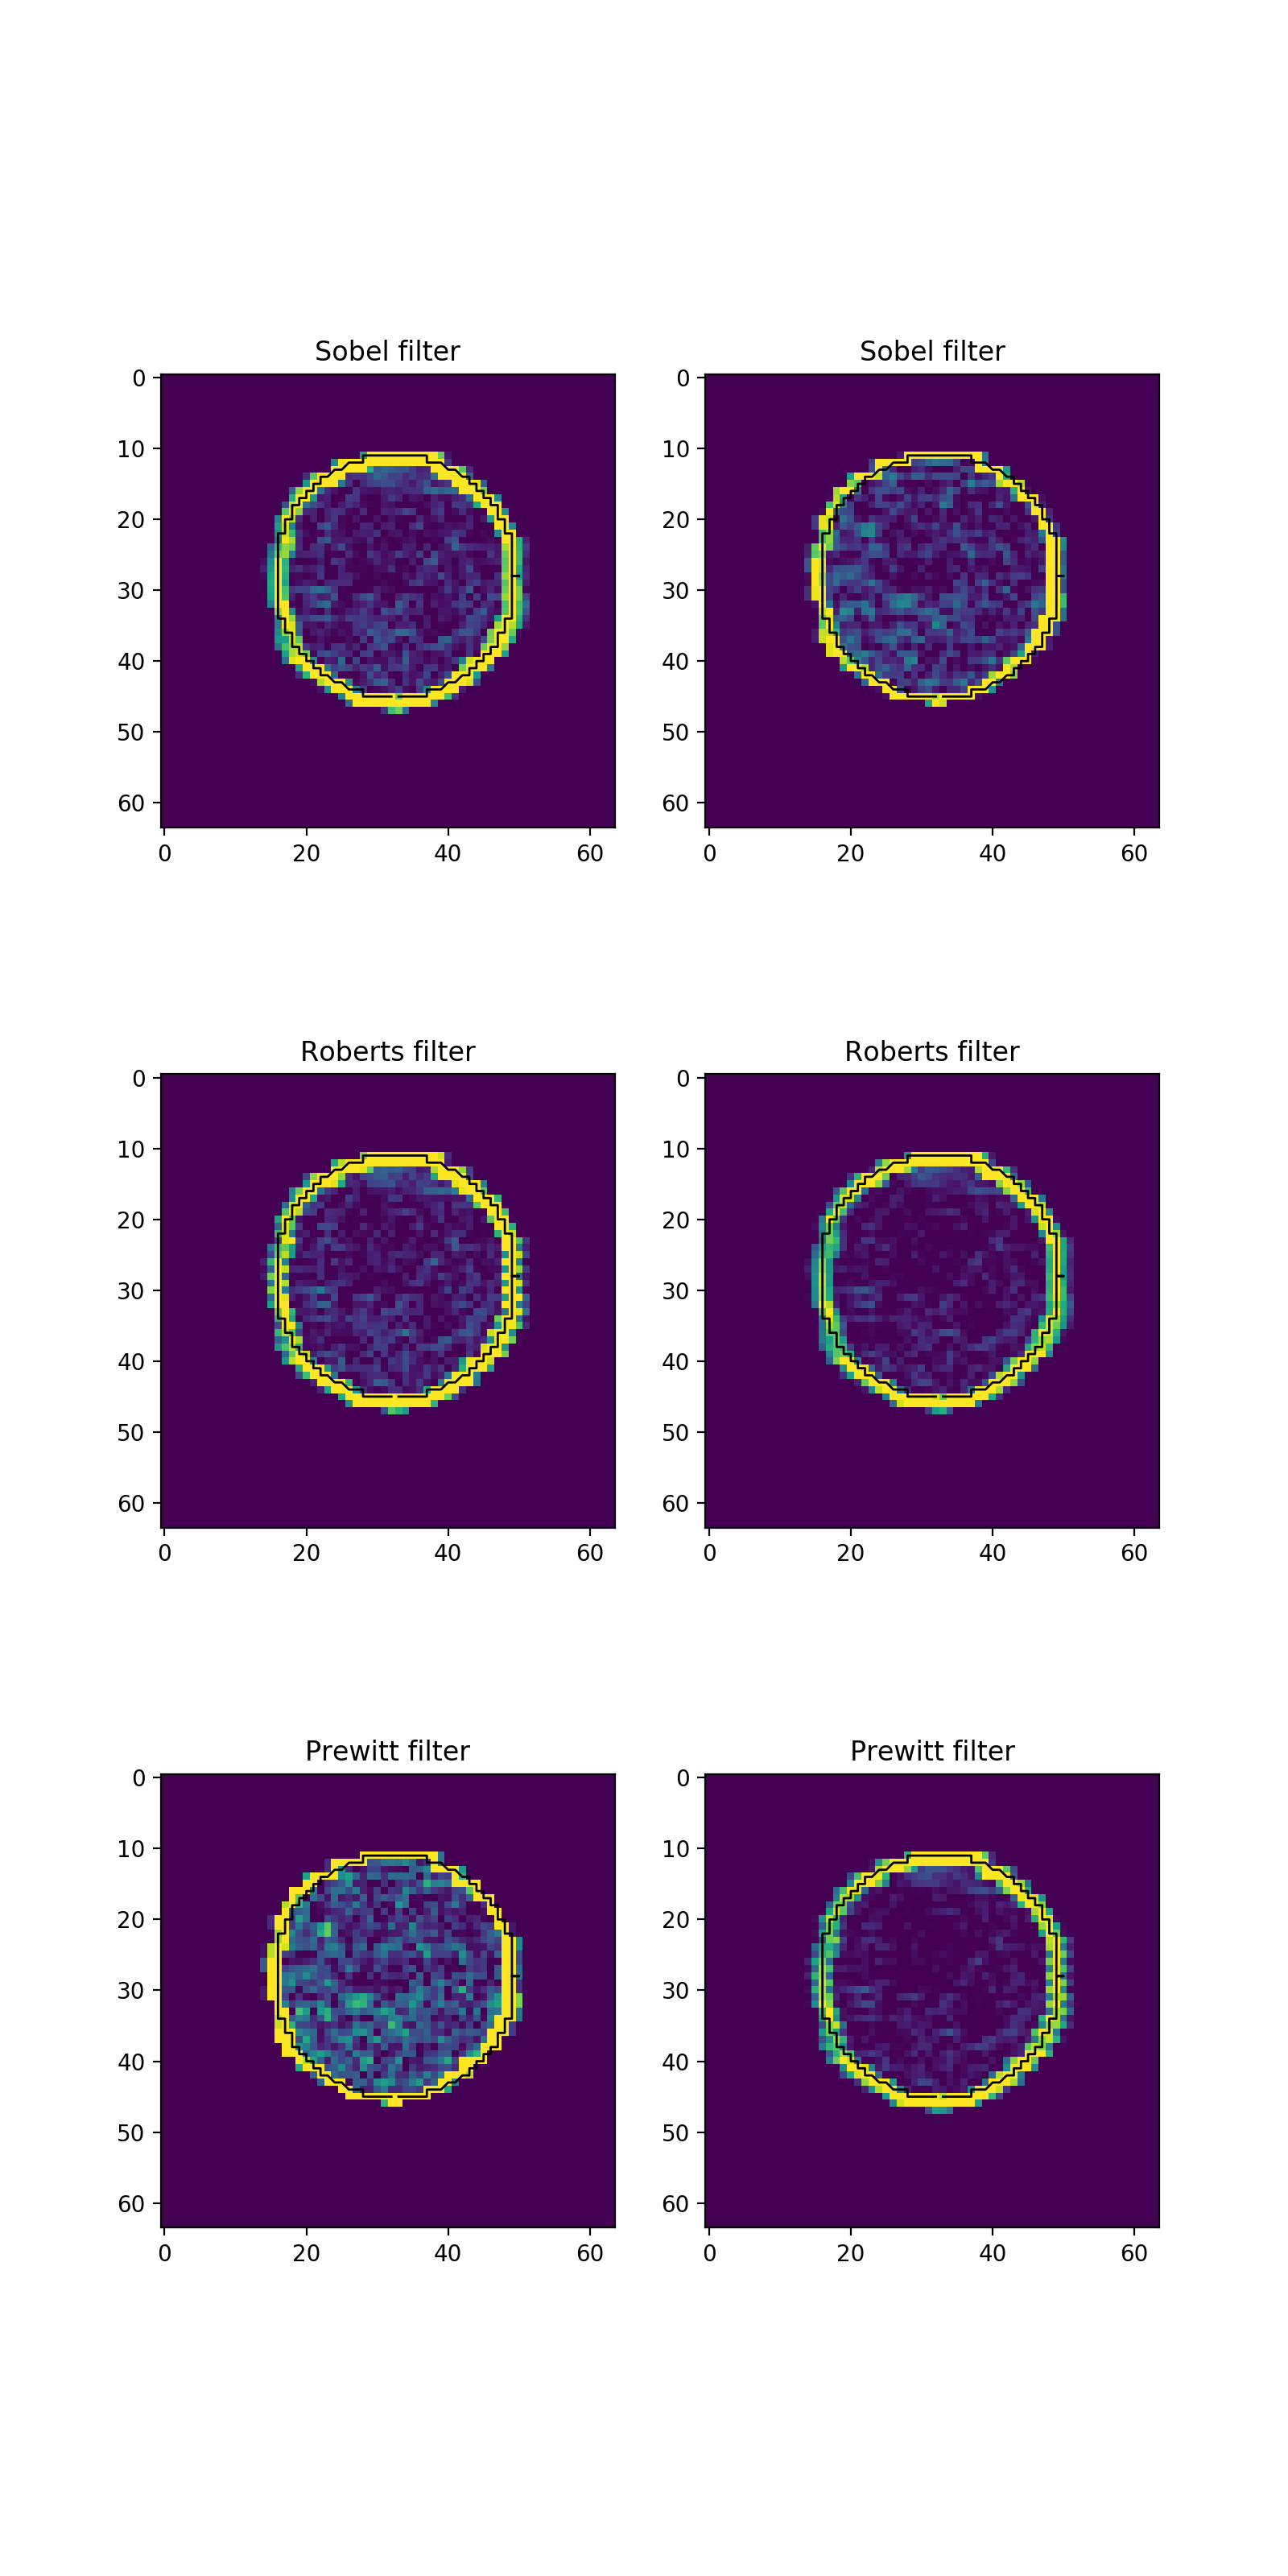

In [31]:
gaussian_sigma = 0.1

img_gaus = np.array(
    map(lambda img: ndimage.gaussian_filter(img, sigma=gaussian_sigma, mode='wrap'), img)
)

sigmas = [0.1, 0.5]
img_gaus_list = []
for s in sigmas:
    img_gaus_list.append(
        np.array(
            map(lambda img: ndimage.gaussian_filter(img, sigma=s, mode='wrap'), img)
        )
    )

fig, (ax_sobel, ax_roberts, ax_prewitt) = plt.subplots(3, 2, figsize=(8, 16))

titles = ['Sobel filter', 'Roberts filter', 'Prewitt filter']
filters = [sobel, roberts, prewitt]
hs = []
for i, axs in enumerate([ax_sobel, ax_roberts, ax_prewitt]):
    for ax_ in axs:
        ax_.set_title(titles[i])
        ax_.plot(x, y, color='black', linewidth=1.0)
        hs.append(ax_.imshow(img_gaus[:,:,0]))

def init():
    for h in hs:
        h.set_data(np.zeros_like(img[:,:,0]))
    return tuple(hs)

def animate(i): 
        
    for ind, h in enumerate(hs):
        image = img_gaus_list[ind % 2][:,:, i]
        edge = filters[ind % 3](image)
        h.set_data(edge)
    
    return tuple(hs)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=t_last, interval=20, blit=True)

if save_video_experiments:
    anim.save('basic_animation_filters.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

we are estimating the gradient inside the space between provided ROI and actual maximum gradient front. 
Trying to average gradient (after construction) around the the configured ROI border.

![separation](https://image.ibb.co/fNaqKa/kek_2.png)

In [62]:
def edge_grad(img, func, kwargs):
    """
    function that makes possible to use any edge detection algorithms
    :param min_R: (max_R - min_R) / separation_count - po for future smoothing
    :param max_R: (max_R - min_R) / separation_count - po for future smoothing
    :separation_count: (max_R - min_R) / separation_count - po for future smoothing
    """
    diff_grad = []
    
    min_boudary = kwargs.get('min_R', 16.7)
    max_boundary = kwargs.get('max_R', 17.3)
    R = (max_boundary + min_boudary) / 2.
    
    separation_count = kwargs.get('separation_count', 10)
    img_count = kwargs.get('img_count', img.shape[-1])

    for R in np.linspace(min_boudary, max_boundary, separation_count):
        local_diff_grad = []
        for i in range(img_count):
            image = img[:,:, i]
            edge_func = func(image)

            t = np.linspace(0, np.pi * 2, img_count)
            x, y = x_ + R * np.sin(t), y_ + R * np.cos(t)
    
            local_diff_grad.append([])
            for xl, yl in zip(x, y):
                local_diff_grad[i].append(edge_func[int(xl), int(yl)])
            
        diff_grad.append(local_diff_grad)
    diff_grad = np.array(diff_grad).sum(axis=0) / separation_count
    return diff_grad

creating an experiment, assembling all parts of processing pipline together in one method

Experiment steps:
- manual bleaching border tuning (choose R, (x, y) - centre of bleaching area)
- Gaussian (linear) averaging on the images
- Sobel, Roberts, Prewitt filter
- Gaussian (linear) averaging of edge detection 

The main purpose of last experiment step is to detect direction of gradient diff. 
Experiment results:

Экспериментальные результаты: 
Достаточно сложно определить какую - то метрику, которая будет оценивать изменение градиента, если необходимо найти только регионы, в которых изменение градиента максимальное - то есть общее направление градиента, то достаточно использовать любой фильтр с аккуратно подобранными коэффициентами для усреднения изображений. Если же стоит задача поиска точечных изменений градиента, что является наиболее интересной задачей, то в такой случае достаточно результатов первого эксперимента (например фильтр Превита с маленькой сигмой для усреднения элементов в окне), так как результаты данного эксперимента сложнее интропретировать из - за большего количества параметров из - за отсутсвия разумных автоматических метрик качества.  

In [262]:
proc = Processing()

def make_experiment(single_filter, roi_imgs, smooth_func=None, win_func=win_gaus, **kwargs):
    
    """
    full experiment function 
    smooth function -> edge detection filter -> averaging by gaussian
    """
    
    smooth_sigma = kwargs.pop('smooth_sigma', 0.3)
    if not smooth_func:
        _frames = proc.process_single_filter(roi_imgs, single_filter)
    else:
        
        roi_imgs_smooth = map(lambda img: smooth_func(img, sigma=smooth_sigma), roi_imgs)
        _frames = proc.process_single_filter(
            np.array(roi_imgs_smooth),
            single_filter
        )
        
    n = kwargs.get('n', 5)
    
    av_roi_img = map(lambda ar: win_gaus(ar, **kwargs), [_frames])

    print np.array(av_roi_img).shape
    return av_roi_img


    
prepared_imgs = make_experiment(
    single_filter=roberts,
    win_func=win_gaus,
    smooth_func=ndimage.gaussian_filter,
    roi_imgs=img,
    n=3,
    smooth_sigma=0.1,
    sigma=1,
    truncate=3
)[0]

np.array(prepared_imgs).shape;


(1, 64, 64, 367)


In [263]:
def plot_image(imgs, save=False, cmap=None):
    def init():
        ax.set_data(imgs[:,:,0])
        return ax,

    def animate(i):
        ax.set_data(imgs[:,:,i])
        return ax,
    
    fig = plt.figure()
    ax = plt.imshow(imgs[:,:,0], cmap=cmap)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=imgs.shape[-1])#, interval=20, blit=True)
    
    if not save:
        return anim
    else:
        anim.save(
            os.path.join(
                'static','{}.avi'.format(
                    datetime.now().strftime('%Y%m%d%H%M%S')
                )
            ),
            fps=1,
            extra_args=['-vcodec', 'libx264']
        )

        return HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>


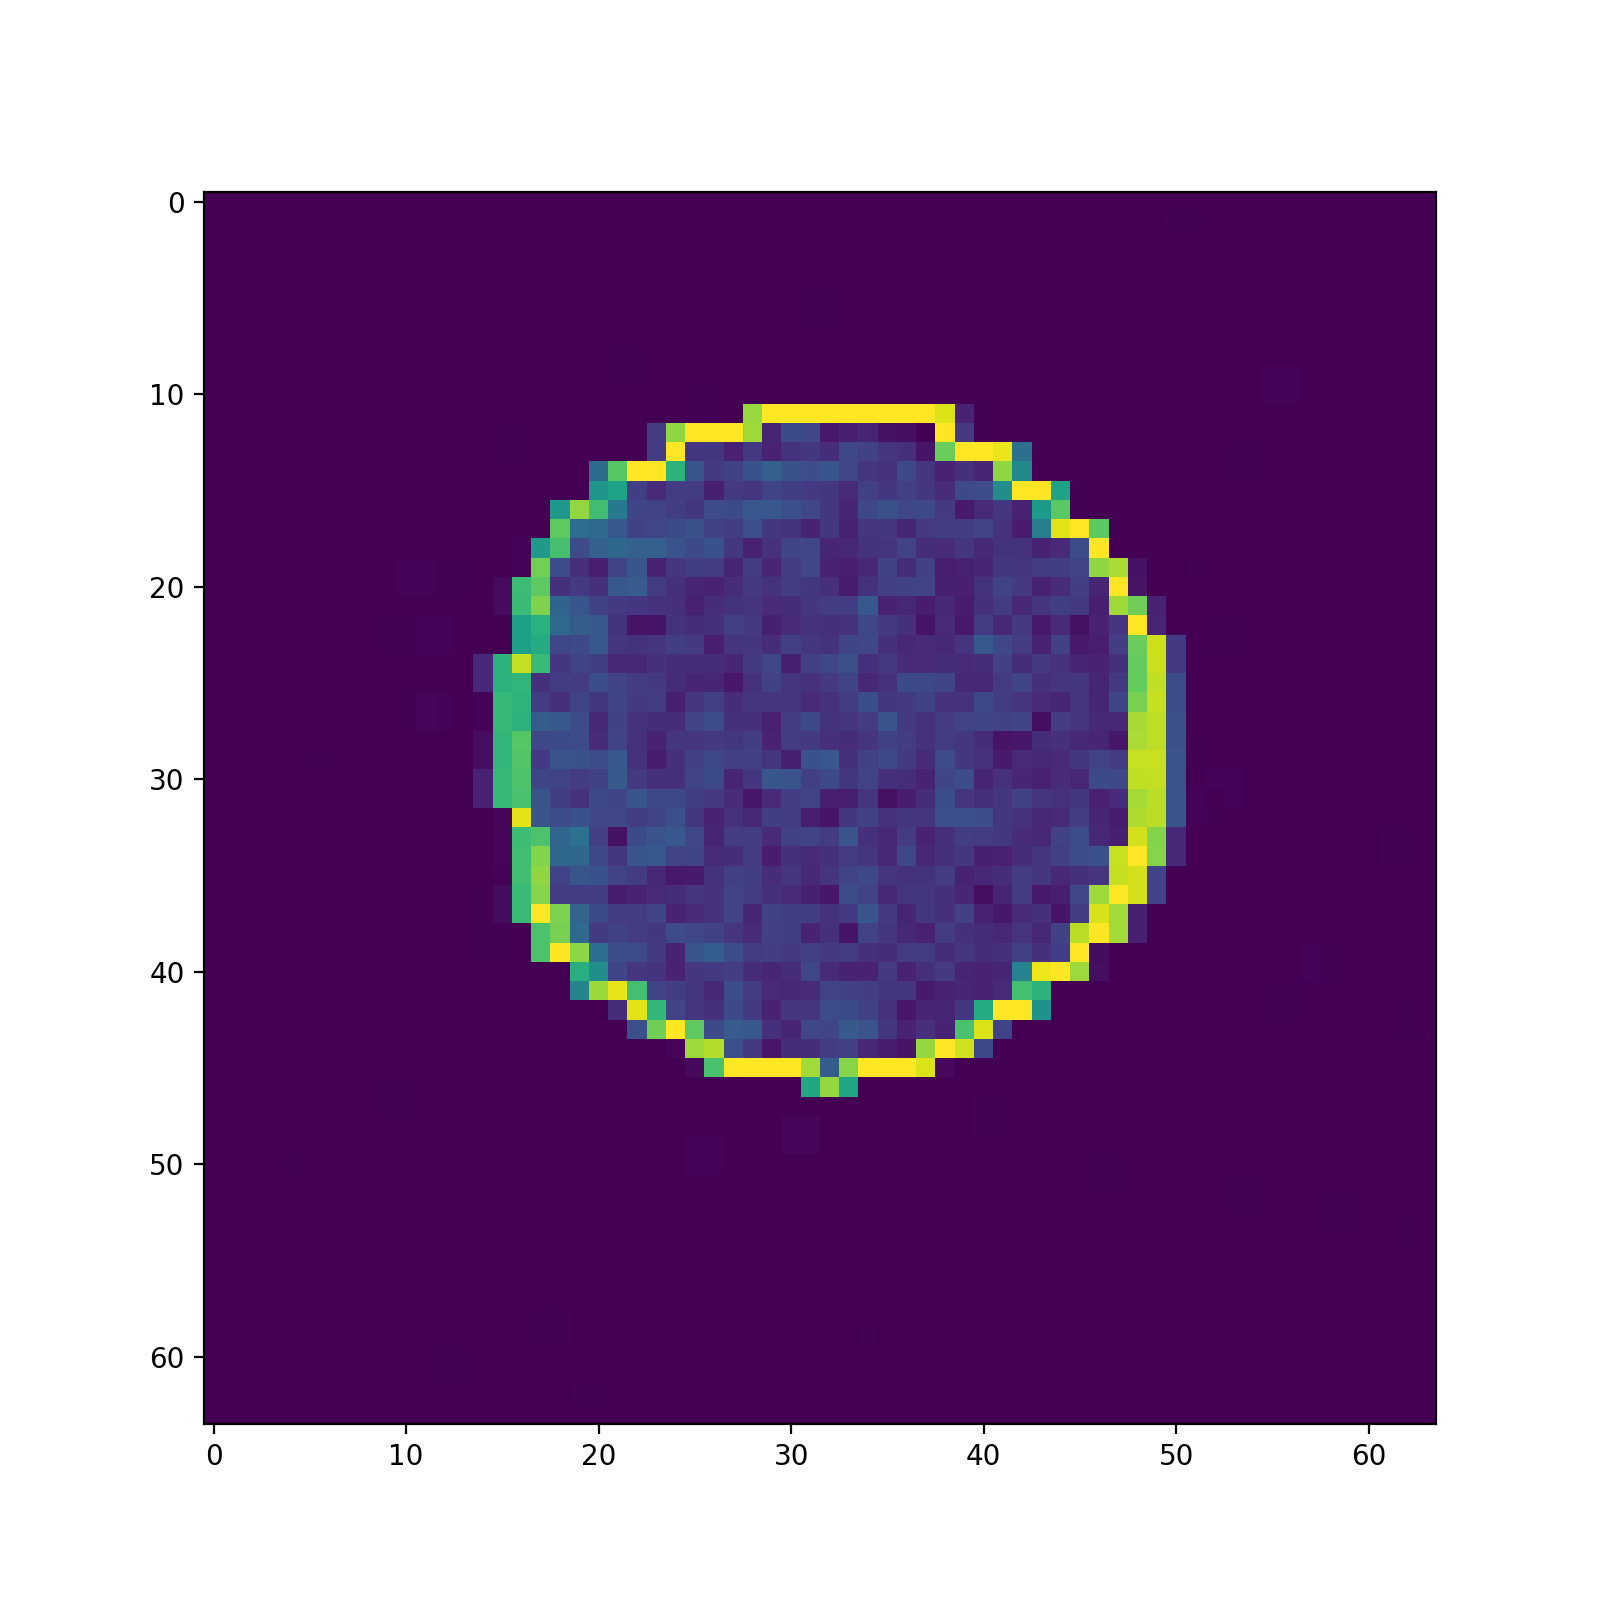

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
h = ax.imshow(prepared_imgs[:,:,0])

def init():
    h.set_data(np.zeros_like(prepared_imgs[:,:, 0]))
    return h

def animate(i):
    h.set_data(prepared_imgs[:,:,i])
    return h

anim = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init, interval=25, blit=True)
if save_video_experiments:
    anim.save('animation_gaus_roberts_gaus.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

In [264]:
py.iplot([
    go.Scatter(x=range(prepared_imgs.shape[-1]),
               y=[prepared_imgs[:,:,i].sum() for i in range(prepared_imgs.shape[-1])],
               line = dict(color = ('rgb(205, 12, 24)'), width = 4), name='values'),
])

# SVD (randomized) + Gauss Smoothing + Sobel Filter + 3D averaging 

the best svd decomposition - the best number of components due to the attached graphic of eigen values distrubution is one

In [265]:
u, s, v = decomposition.randomized_svd(M, n_components=3)
low_rank = np.dot(np.dot(u, np.diag(s)), v)

In [267]:
svd_imgs = make_experiment(
    single_filter=roberts,
    win_func=win_gaus,
    smooth_func=ndimage.gaussian_filter,
    roi_imgs=np.reshape(low_rank, img.shape),
    n=3,
    smooth_sigma=0.1,
    sigma=1,
    truncate=3
)[0]


(1, 64, 64, 367)


In [56]:
plot_plotly_svd(np.reshape(svd_imgs, (4096, 367)))

In [268]:
py.iplot([
    go.Scatter(x=range(svd_imgs.shape[-1]),
               y=[svd_imgs[:,:,i].sum() for i in range(svd_imgs.shape[-1])],
               line = dict(color = ('rgb(205, 12, 24)'), width = 4), name='values'),
])

In [288]:
low_rank_ = np.reshape(low_rank, (64,64, 369))
py.iplot([
    go.Scatter(x=range(low_rank_.shape[-1]),
               y=[low_rank_[:,:,i].sum() for i in range(low_rank_.shape[-1])],
               line = dict(color = ('rgb(205, 12, 24)'), width = 4), name='values'),
])

# QR factorization + Gauss Smoothing + Sobel Filter + 3D averaging 

In [275]:
qr_imgs = make_experiment(
    single_filter=roberts,
    win_func=win_gaus,
#     smooth_func=ndimage.gaussian_filter,
    roi_imgs=np.reshape(np.dot(Q, R), img.shape),
    n=3,
    smooth_sigma=0.1,
    sigma=1,
    truncate=3
)[0]

plot_plotly_svd(np.reshape(qr_imgs, (4096, 367)))


(1, 64, 64, 367)


In [277]:
py.iplot([
    go.Scatter(x=range(qr_imgs.shape[-1]),
               y=[qr_imgs[:,:,i].sum() for i in range(qr_imgs.shape[-1])],
               line = dict(color = ('rgb(205, 12, 24)'), width = 4), name='values'),
])

## QUIVER plot - gradients

experiments with quiver plot can show us the correct direction of the gradient during the photobleaching

<IPython.core.display.Javascript object>


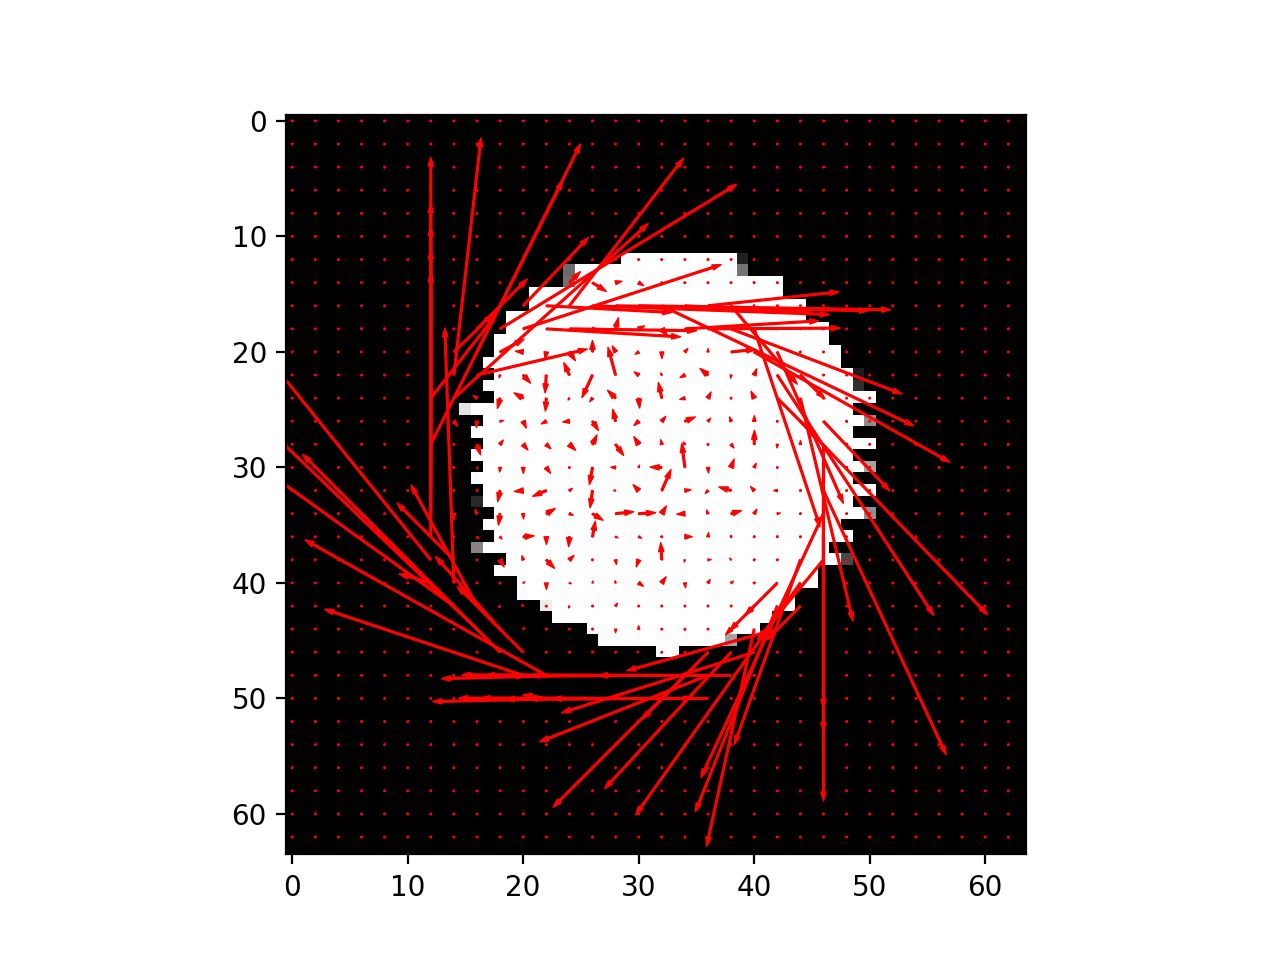

In [36]:
# NEED MORE TESTS
from skimage.filters import (sobel_h, sobel_v)
from skimage.filters import prewitt_h, prewitt_v

n_ = 2

sobel_frames = (np.zeros_like(img), np.zeros_like(img))
for i in range(img.shape[-1]):
    sobel_frames[0][:,:,i] = sobel_h(img[:,:,i])
    sobel_frames[1][:,:,i] = sobel_v(img[:,:,i])
    
average_roi_img = map(lambda ar: win_average(ar,n=3), sobel_frames)

shape = img.shape
Ymesh, Xmesh = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))

fig = plt.figure()
V, U = average_roi_img

Q = plt.quiver(Xmesh[::n_, ::n_], Ymesh[::n_, ::n_], U[::n_, ::n_, 0], V[::n_, ::n_, 0],
               color='r', 
               units='x',
               linewidths=(0.5,),
               edgecolors=('r'),
               headaxislength=5)

ax = plt.imshow(img[:,:,0], cmap=plt.cm.gray)

def init():
    Q.set_UVC(U[::n_, ::n_, 0], V[::n_, ::n_, 0])
    ax.set_data(img[:,:,0])
    return Q,

def animate(i):
    Q.set_UVC(U[::n_, ::n_, i], V[::n_, ::n_, i])
    ax.set_data(img[:,:,i])
    return Q,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=60, interval=400, blit=True)

In [ ]:
from skimage import ndimage

dx = ndimage.sobel(your3Dmatrix, 0)  # x derivative
dy = ndimage.sobel(your3Dmatrix, 1)  # y derivative
dz = ndimage.sobel(your3Dmatrix, 2)  # z derivative

In [37]:
fig = ff.create_quiver(x=Xmesh[::n_, ::n_], y=Ymesh[::n_, ::n_], u=U[::n_, ::n_, 5], v=V[::n_, ::n_, 5], scale=5)
py.iplot(fig)

Searching for a better fit - an actual ROI border

In [68]:
%%time

diff_grad_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.5,
        'max_R': 17.5,
        'separation_count': 20,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_roberts = edge_grad(
    img, 
    roberts,
    {
        'min_R': 16.7,
        'max_R': 17.4,
        'separation_count': 50,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_prewitt = edge_grad(
    img, 
    prewitt,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img.shape[-1],
        't': 60
    }
)


diff_grad_gaus_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img_gaus.shape[-1],
        't': 60
    }
)

assert diff_grad_sobel.shape == (369, 369)
assert diff_grad_roberts.shape == (369, 369)
assert diff_grad_prewitt.shape == (369, 369)

CPU times: user 29.2 s, sys: 693 ms, total: 29.9 s
Wall time: 30.1 s


In [90]:
diff_grad_qr_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': qr_imgs.shape[-1],
        't': 60
    }
)

In [69]:
# STANDARD ANIMATED PLOT
def standard_plot(diff_grad, save=None):
    fig, ax = plt.subplots()
    x = np.arange(len(diff_grad[0]))
    line, = ax.plot(x, diff_grad[0])

    def animate(i):
        line.set_ydata(diff_grad[i])  # update the data
        return line,

    # Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,

    ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                                  interval=25, blit=True)
    if save:
        ani.save(save, fps=30, extra_args=['-vcodec', 'libx264'])
        
    plt.show()

comparing different combinations of filters and smoothing kernels

Результаты экспериментов: 
Одной из наиболее разумных идей - использовать сравнение абсолютных величин вычисления градиента
Так как разумных автоматических метрик качества найти не удалось, то для наглядности кривые вычисление градиента были наложены на полярные координаты. В такой интропретации легко заметить пики, что соответсвует общему направлению изменения градиента 
Также можно наблюдать рваные кривые, что отображает локальные изменения и шум (предположительно в большей части это шум)

<IPython.core.display.Javascript object>


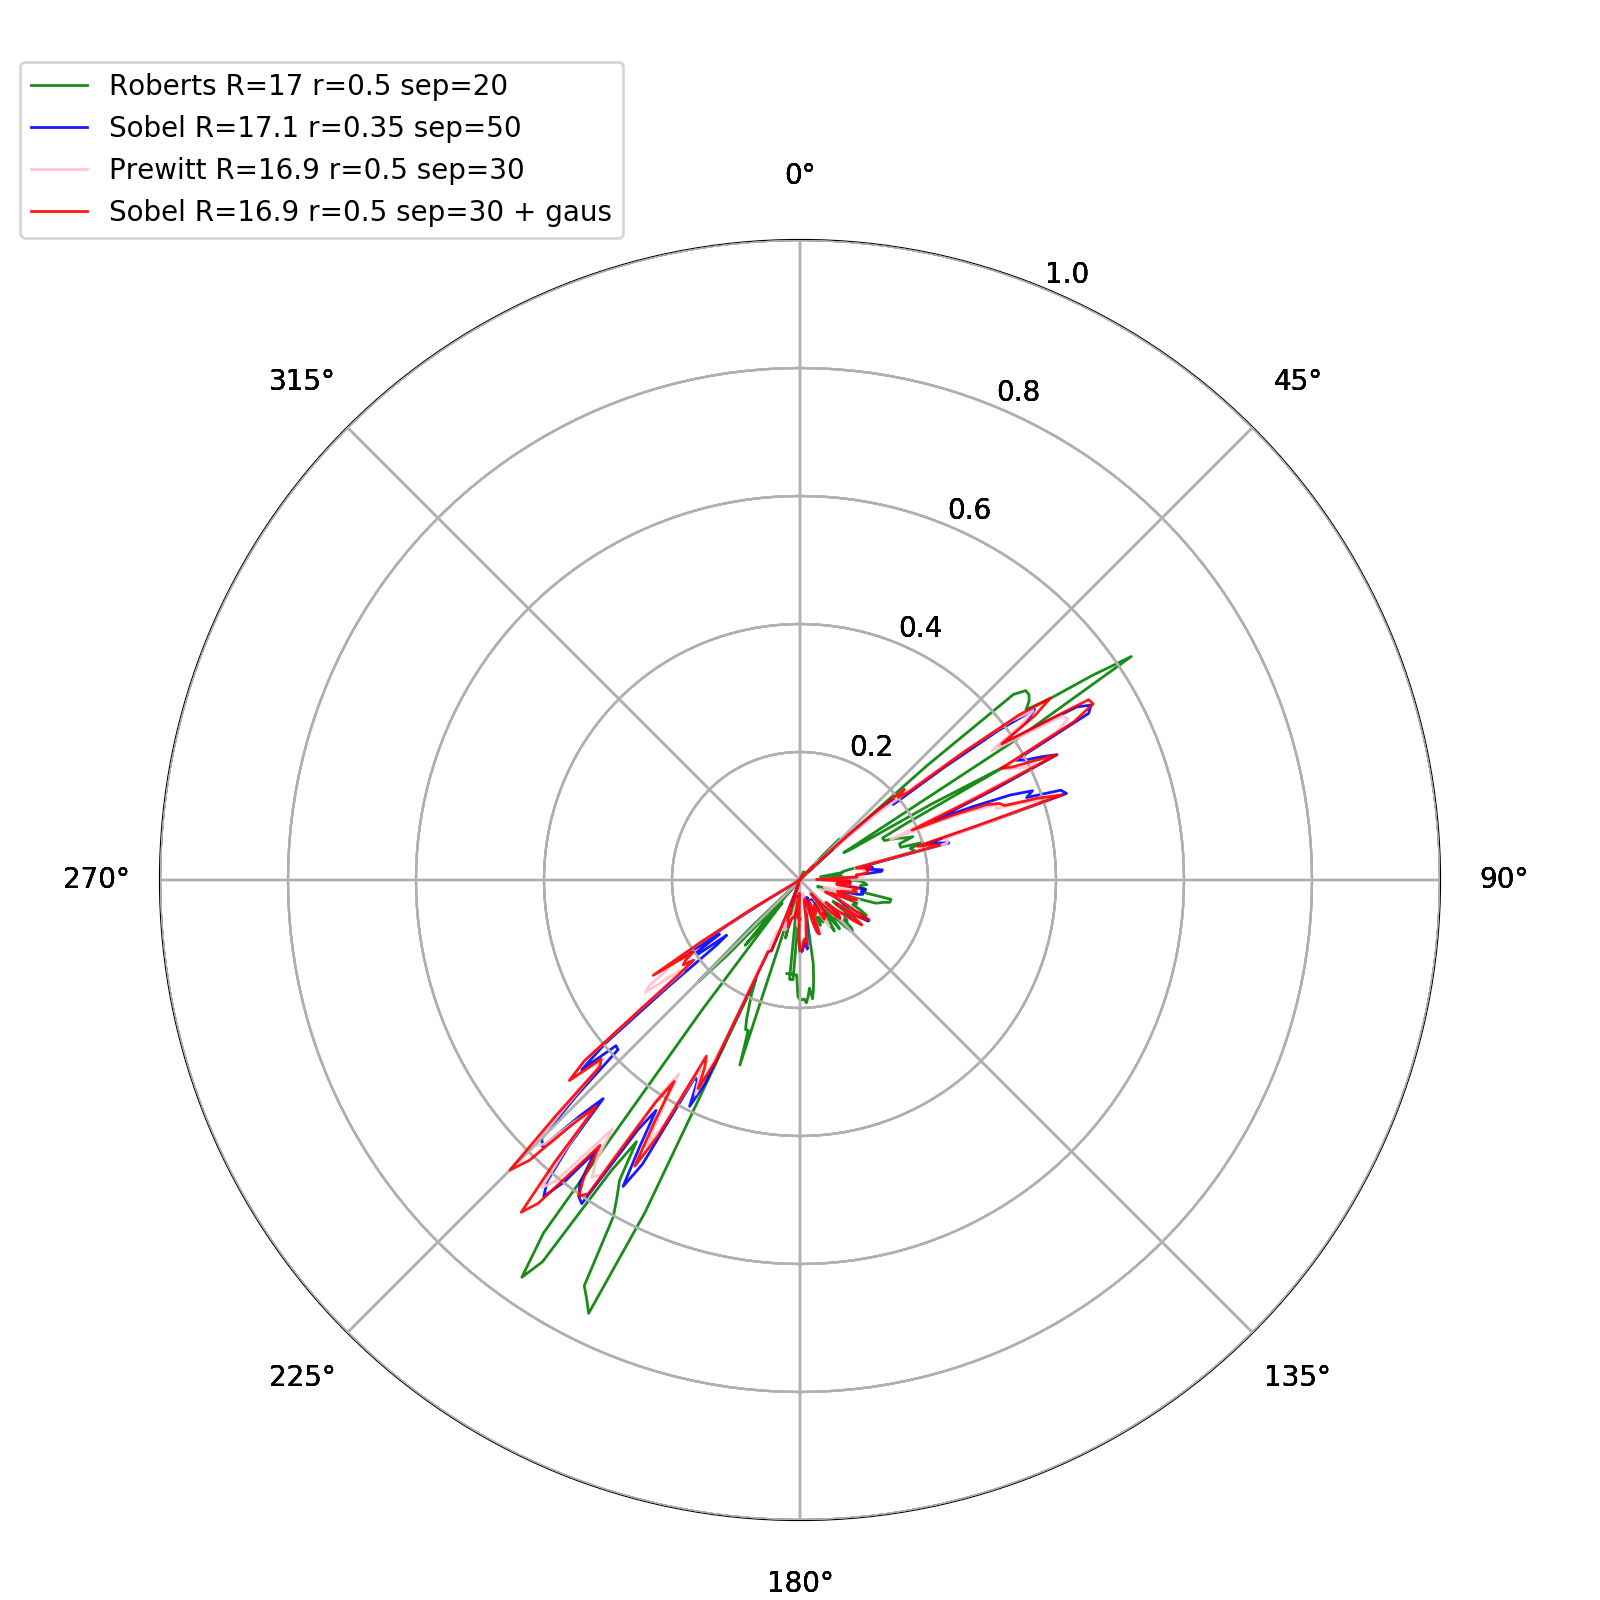

In [278]:
# implementation of visualisation

def data_gen():
    x = np.arange(-180.0, 190.0, 370 / img.shape[-1])[:img.shape[-1]]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(img.shape[-1]):
        yield (theta, diff_grad_roberts[i], diff_grad_sobel[i], diff_grad_prewitt[i], diff_grad_gaus_sobel[i])
    
def init():
    del theta[:]
    del R1[:]
    del R2[:]
    del R3[:]
    del R4[:]
    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    line4.set_data(theta, R4)
    return line, line2, line3, line4,

def polar_twin(ax):
    ax2 = ax.figure.add_axes(
        ax.get_position(), 
        projection='polar', 
        label='twin',
        frameon=False,
        theta_direction=ax.get_theta_direction(),
        theta_offset=ax.get_theta_offset()
    )

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=len(ax.get_yticks())))
    ax2.set_ylim(0, ax2.get_yticks()[-1])
    ax2.yaxis.get_major_ticks()[0].label1.set_visible(False)
    return ax2

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True, theta_direction=-1, theta_offset=np.pi/2)
ax.set_ylim(0, 1)
ax2 = polar_twin(ax)
ax3 = polar_twin(ax)
ax4 = polar_twin(ax)

line, = ax.plot([], [], lw=1, alpha=.9, c='green', label='Roberts R=17 r=0.5 sep=20')
line2, = ax2.plot([], [], lw=1, alpha=.9, c='blue', label='Sobel R=17.1 r=0.35 sep=50')
line3, = ax3.plot([], [], lw=1, alpha=.9, c='pink', label='Prewitt R=16.9 r=0.5 sep=30')
line4, = ax4.plot([], [], lw=1, alpha=0.9, c='red', label='Sobel R=16.9 r=0.5 sep=30 + gaus')

ax.legend(
    [line, line2, line3, line4,],
    [line.get_label(), line2.get_label(), line3.get_label(), line4.get_label(),],
    loc='upper left', bbox_to_anchor=(-0.12, 1.15)
)

theta, R1, R2, R3, R4 = [], [], [], [], []

def run(data): 
    theta, R1, R2, R3, R4 = data

    offset = 2.0

    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    line4.set_data(theta, R4)   
    return line, line2, line3, line4,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=20, repeat=False)
if save_video_experiments:
    anim.save('polar_abs_grad_with_gaus.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
#     HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>


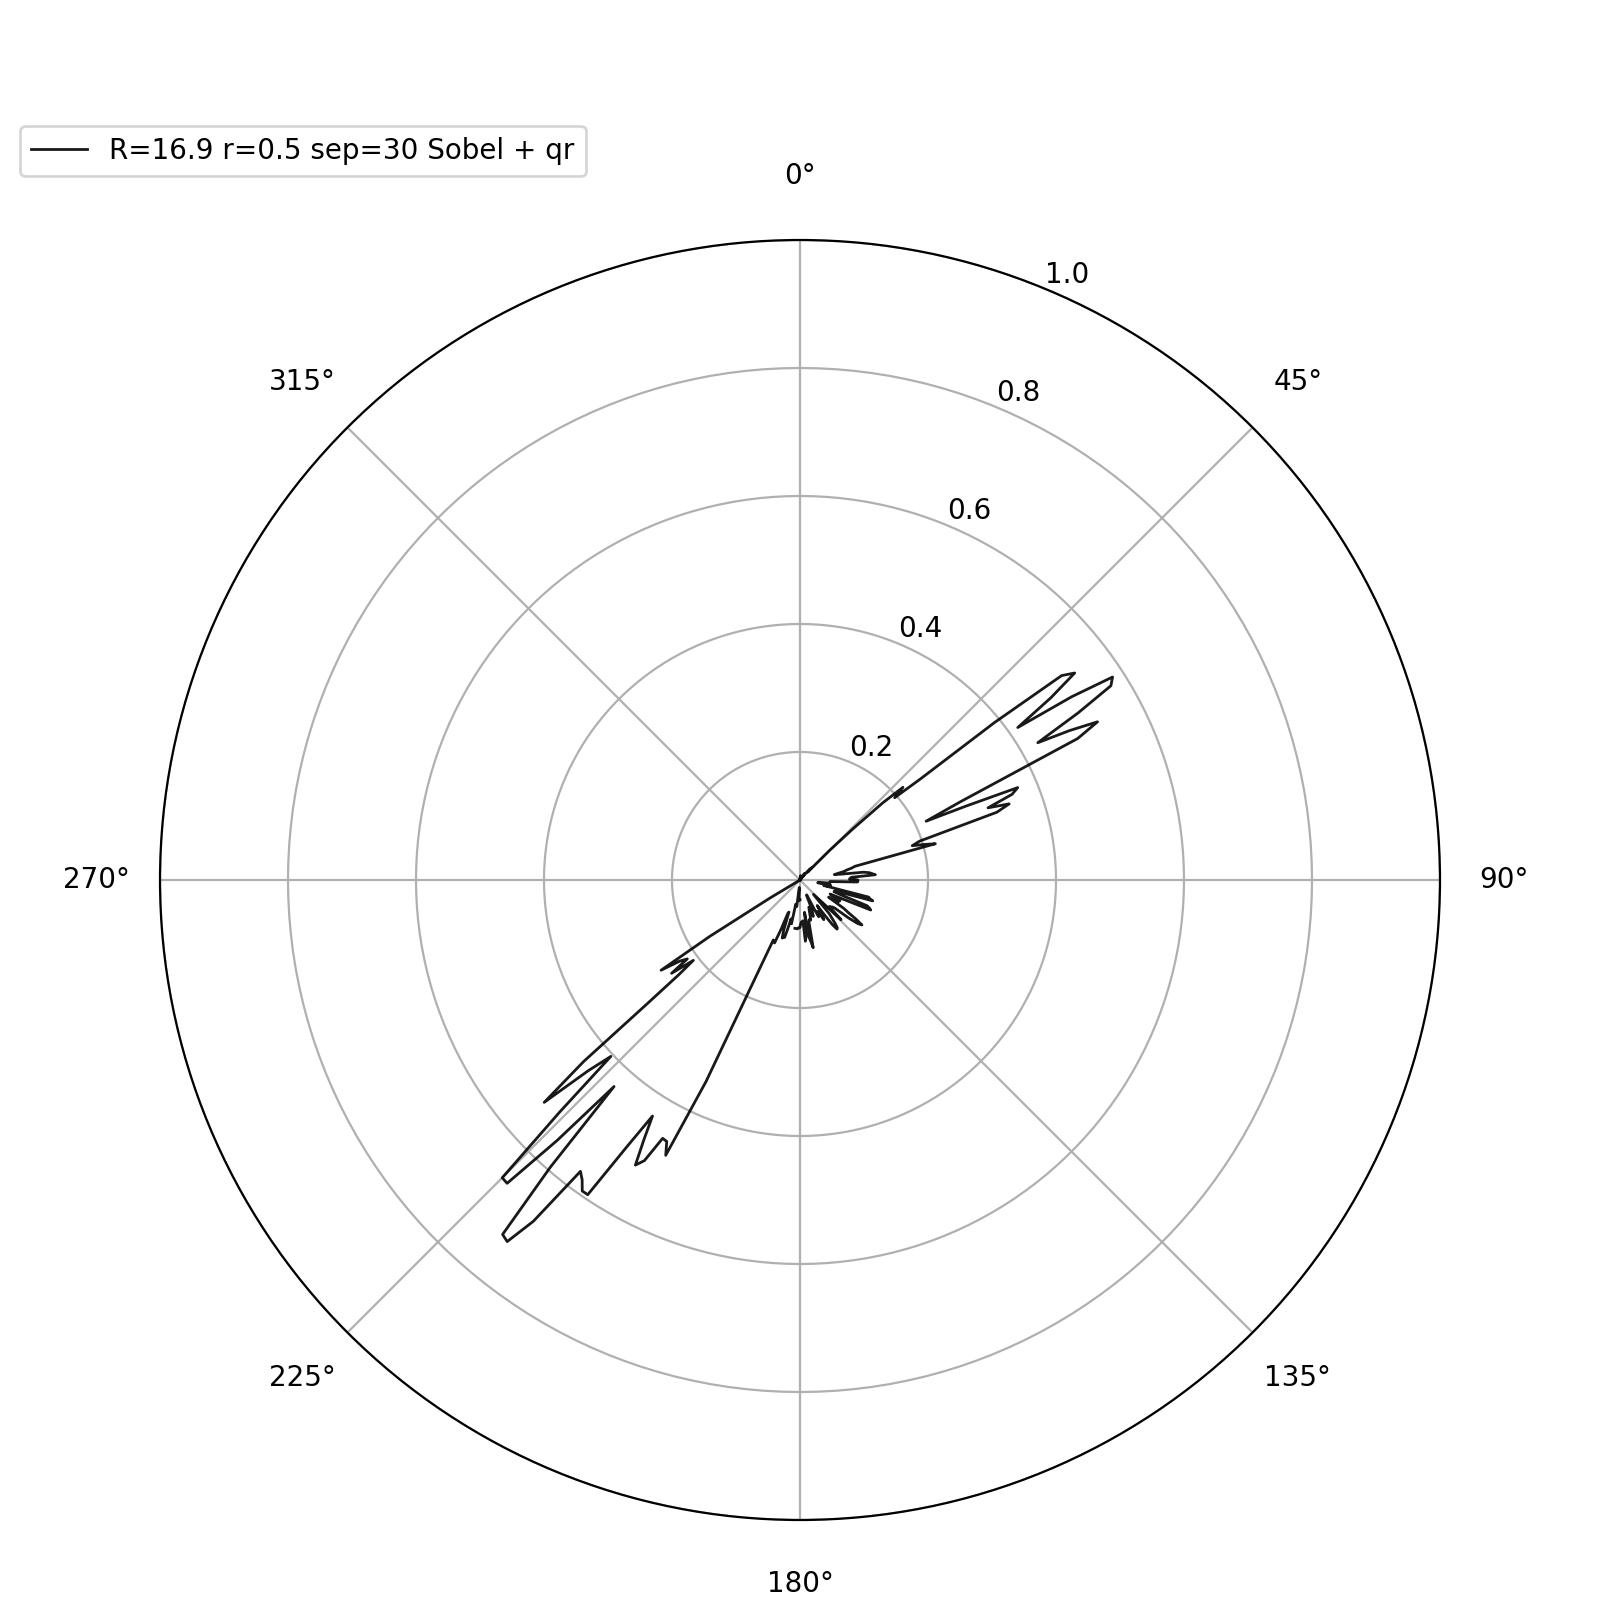

In [270]:
def data_gen():
    x = np.arange(-180.0, 190.0, 370 / qr_imgs.shape[-1])[:qr_imgs.shape[-1]]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(img.shape[-1]):
        yield (theta, diff_grad_qr_sobel[i],)
    
def init():
    del theta[:]
    del R1[:]
    line.set_data(theta, R1)
    return line, 

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True, theta_direction=-1, theta_offset=np.pi/2)
ax.set_ylim(0, 1)
line, = ax.plot([], [], lw=1, alpha=0.9, c='black', label='R=16.9 r=0.5 sep=30 Sobel + qr')
ax.legend([line,], [line.get_label(),], loc='upper left', bbox_to_anchor=(-0.12, 1.1))

theta, R1 = [], []
def run(data): 
    theta, R1 = data
    offset = 2.0
    line.set_data(theta, R1) 
    return line,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=20, repeat=False)
if save_video_experiments:
    anim.save('polar_abs_grad_with_qr.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

In [193]:
stop_bioformats()

BioContainer closed
